In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import logging
import numpy as np
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import svm
from datetime import datetime
import os
from gensim.models.word2vec import Word2Vec
import gensim
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from collections import defaultdict

import embeddingvectorizer
from nltk.corpus import stopwords

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
import json

In [87]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [37]:
path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")
data = df['text']
labels = df['topic']

In [118]:
basepath = '/home/anne/tmpanne/fullsample/'

class word2vec_analyzer():
    '''This class tests the efficacy of Word2Vec models in downstream tasks.'''

    def __init__(self):
        self.nmodel = 0
        self.vectorizer = 'Tfidf'
        self.train_sizes = [10, 40, 160, 640, 1000, 2500] 
        self.data = data
        self.labels = labels
    

    def get_w2v_model(self):
        '''yields a dict with one item. key is the filename, value the gensim model'''
        
        filenames = [e for e in os.listdir(basepath) if not e.startswith('.')]

        for fname in filenames:
            model = {}
            path = os.path.join(basepath, fname)
            logger.info("\nLoading gensim model")
            mod = gensim.models.Word2Vec.load(path)
            model['gensimmodel'] = dict(zip(mod.wv.index2word, mod.wv.vectors))
            model['filename'] = fname
            self.nmodel +=1
            logger.info("loaded gensim model nr {}, named: {}".format(self.nmodel, model['filename']))
            yield model
        
    def benchmark(self, model, X, y, n):
        test_size = 1 - (n / float(len(y)))
        print("test size: {}".format(test_size))
        scores = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
        print("mean scores: {}".format(np.mean(scores)))
        return np.mean(scores)
            
    def get_baseline_results(self):
        results = [] 
        if self.vectorizer == "Tfidf":
            logger.info(">>>> defining pipes for baseline model with {} vectorizer".format( self.vectorizer))

            svm = Pipeline([("vect", TfidfVectorizer()),
                            ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
                            ])

            
            ET = Pipeline([
                ("vect", TfidfVectorizer()),
                ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
                ])
            
    
        else:
            logger.info(">>>> defining pipes for baseline model with {} vectorizer".format( self.vectorizer))
            svm = Pipeline([("vect", CountVectorizer()),
                            ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
                            ])
            
            ET = Pipeline([
                ("vect", CountVectorizer()),
                ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
                ])
            
        all_models = [ ( "svm" , svm ) , ("ET", ET), ]
        
        results = []
        for name, model in all_models:
            for n in self.train_sizes:
                print(name)
                results.append({'classifier': name, 
                                'model' : "baseline" , 
                                'accuracy': self.benchmark(model, self.data, self.labels, n), 
                                'train_size': n})        
        return results
      
               
    def get_scores_wv2(self):
        
        results = []
        
        for model in self.get_w2v_model():
            
            if self.vectorizer == "Tfidf":
                logger.info(">>>> defining pipes for model {} with {} vectorizer".format(model['filename'], self.vectorizer))

                w2v_svm = Pipeline([
                ("word2vec TfidF vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model['gensimmodel'])),
                ("svm", SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42, penalty='elasticnet'))
                ])

                w2v_ET = Pipeline([
                ("word2vec tfidf vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model['gensimmodel'])), 
                ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
                ])

            else:
                logger.info(">>>> defining pipes for model {} with {} vectorizer".format(model['filename'], self.vectorizer))

                w2v_svm = Pipeline([
                ("word2vec TfidF vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model['gensimmodel'])),
                ("svm", SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42, penalty='elasticnet'))
                ])

                w2v_ET = Pipeline([
                ("word2vec tfidf vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model['gensimmodel'])), 
                ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
                ])

            all_models = [ ( "w2v_svm" , w2v_svm ) , ("w2v_ET ", w2v_ET ), ]
            
            table = []
            for name, m in all_models:
                for n in self.train_sizes:
                    print(name)
                    table.append({'classifier': name, 
                                    'model' : model['filename'] ,
                                    'accuracy': self.benchmark(m, self.data, self.labels, n), 
                                    'train_size': n})
            results.append(table)
        return results
        
    def get_final(self):
        results_wv2 = self.get_scores_wv2() 
        results_baseline = self.get_baseline_results()
        return results_baseline, results_wv2
            
if __name__ == "__main__":

    logger = logging.getLogger()
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
    logging.root.setLevel(level=logging.INFO)
    
    myanalyzer = word2vec_analyzer()
    my_results = myanalyzer.get_final()
    
    with open('output_my_results.json',mode='w') as fo:
        fo.write('[')
        
        for result in my_results:
            fo.write(json.dumps(result))
            fo.write(',\n')
        fo.write('[]]')
        print("\n\n\nSave results\n\n\n")

    df = pd.DataFrame.from_dict(my_results)
    print('Created dataframe')
    print(df)
    df.to_csv('w2v_evaluation.csv')

INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_5_window_10_size_300_negsample_5
INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_5_window_10_size_300_negsample_5
INFO:root:loaded gensim model nr 1, named: w2v_model_nr_5_window_10_size_300_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_5_window_10_size_300_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.6311852704257768
w2v_svm
test size: 0.9885255306942053
mean scores: 0.5107370864770748
w2v_svm
test size: 0.9541021227768216
mean scores: 0.6740829825616356
w2v_svm
test size: 0.8164084911072863
mean scores: 0.8120168657765284
w2v_svm
test size: 0.7131382673551347
mean scores: 0.8045052292839904
w2v_svm
test size: 0.2828456683878371
mean scores: 0.817629179331307
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5920598388952819
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.698200812536274
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7660853878532772
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8011243851018974
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8032984714400644
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_1_window_5_size_300_negsample_5


mean scores: 0.8166160081053698


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_1_window_5_size_300_negsample_5
INFO:root:loaded gensim model nr 2, named: w2v_model_nr_1_window_5_size_300_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_1_window_5_size_300_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.5903337169159953
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6639582124201974
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7609741431148527
w2v_svm
test size: 0.8164084911072863
mean scores: 0.8120168657765284
w2v_svm
test size: 0.7131382673551347
mean scores: 0.8089300080450523
w2v_svm
test size: 0.2828456683878371
mean scores: 0.8125633232016211
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.562428078250863
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6950087057457922
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7672880336740829
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.7986647926914968
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.7964601769911505
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_8_window_47615_size_100_negsample_5


mean scores: 0.8135764944275583


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_8_window_47615_size_100_negsample_5
INFO:root:loaded gensim model nr 3, named: w2v_model_nr_8_window_47615_size_100_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_8_window_47615_size_100_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.4887802071346375
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6622170632617528
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7348165965123271
w2v_svm
test size: 0.8164084911072863
mean scores: 0.8099086437104709
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7646822204344328
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7872340425531915
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5883199079401611
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6929773650609402
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7597714972940469
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8035839775122979
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8016894609814964
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_11_window_47615_size_300_negsample_15


mean scores: 0.817629179331307


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_11_window_47615_size_300_negsample_15
INFO:root:loaded gensim model nr 4, named: w2v_model_nr_11_window_47615_size_300_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_11_window_47615_size_300_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.43814729574223243
w2v_svm
test size: 0.9885255306942053
mean scores: 0.5507835171213
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7874323511725797
w2v_svm
test size: 0.8164084911072863
mean scores: 0.7877723120168658
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7864038616251006
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7963525835866262
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.620253164556962
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6909460243760882
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7708959711365003
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.7969079409697821
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8045052292839904
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_4_window_10_size_100_negsample_5


mean scores: 0.8115501519756839


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_4_window_10_size_100_negsample_5
INFO:root:loaded gensim model nr 5, named: w2v_model_nr_4_window_10_size_100_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_4_window_10_size_100_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.3693901035673188
w2v_svm
test size: 0.9885255306942053
mean scores: 0.7109692396982008
w2v_svm
test size: 0.9541021227768216
mean scores: 0.756464221286831
w2v_svm
test size: 0.8164084911072863
mean scores: 0.8000702740688685
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7980691874497184
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7588652482269503
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5808400460299195
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6906558328496808
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7726999398677089
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8039353478566409
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8049074818986324
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_9_window_47615_size_300_negsample_5


mean scores: 0.8216818642350557


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_9_window_47615_size_300_negsample_5
INFO:root:loaded gensim model nr 6, named: w2v_model_nr_9_window_47615_size_300_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_9_window_47615_size_300_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.4830264672036824
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6979106210098666
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7384245339747444
w2v_svm
test size: 0.8164084911072863
mean scores: 0.7796907940969782
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7775543041029767
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7963525835866262
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.562428078250863
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6703424260011608
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7675886951292844
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.797962052002811
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.7944489139179405
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_3_window_5_size_300_negsample_15


mean scores: 0.8105369807497467


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_3_window_5_size_300_negsample_15
INFO:root:loaded gensim model nr 7, named: w2v_model_nr_3_window_5_size_300_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_3_window_5_size_300_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.39010356731875717
w2v_svm
test size: 0.9885255306942053
mean scores: 0.5441091120139292
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7549609140108238
w2v_svm
test size: 0.8164084911072863
mean scores: 0.7821503865073788
w2v_svm
test size: 0.7131382673551347
mean scores: 0.8037007240547064
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7750759878419453
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5491944764096662
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.675275681950087
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7627781118460614
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.7926914968376669
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.7988736926790024
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_10_window_47615_size_100_negsample_15


mean scores: 0.8135764944275583


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_10_window_47615_size_100_negsample_15
INFO:root:loaded gensim model nr 8, named: w2v_model_nr_10_window_47615_size_100_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_10_window_47615_size_100_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.4982738780207135
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6340684852002322
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7582681900180397
w2v_svm
test size: 0.8164084911072863
mean scores: 0.791988756148981
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7956556717618665
w2v_svm
test size: 0.2828456683878371
mean scores: 0.78419452887538
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5946490218642118
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6877539175856066
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7766085387853278
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8025298664792692
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8049074818986324
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_7_window_10_size_300_negsample_15


mean scores: 0.8226950354609929


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_7_window_10_size_300_negsample_15
INFO:root:loaded gensim model nr 9, named: w2v_model_nr_7_window_10_size_300_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_7_window_10_size_300_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.619102416570771
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6979106210098666
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7282020444978954
w2v_svm
test size: 0.8164084911072863
mean scores: 0.809205903021785
w2v_svm
test size: 0.7131382673551347
mean scores: 0.8169750603378922
w2v_svm
test size: 0.2828456683878371
mean scores: 0.8105369807497467
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5575373993095513
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.691526407428903
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7736019242333133
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8025298664792692
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8028962188254224
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_6_window_10_size_100_negsample_15


mean scores: 0.817629179331307


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_6_window_10_size_100_negsample_15
INFO:root:loaded gensim model nr 10, named: w2v_model_nr_6_window_10_size_100_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_6_window_10_size_100_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.36565017261219795
w2v_svm
test size: 0.9885255306942053
mean scores: 0.6784677887405688
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7636800962116657
w2v_svm
test size: 0.8164084911072863
mean scores: 0.7997189037245257
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7111826226870475
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7527862208713273
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.5517836593785961
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6816598955310504
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7766085387853278
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8021784961349262
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8008849557522124
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_2_window_5_size_100_negsample_15


mean scores: 0.8216818642350557


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_2_window_5_size_100_negsample_15
INFO:root:loaded gensim model nr 11, named: w2v_model_nr_2_window_5_size_100_negsample_15
INFO:root:>>>> defining pipes for model w2v_model_nr_2_window_5_size_100_negsample_15 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.5273302646720368
w2v_svm
test size: 0.9885255306942053
mean scores: 0.5739988392338944
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7666867107636801
w2v_svm
test size: 0.8164084911072863
mean scores: 0.8049894588896697
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7719227674979887
w2v_svm
test size: 0.2828456683878371
mean scores: 0.7396149949341438
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.570771001150748
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6735345327916424
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7615754660252556
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.7993675333801827
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.7992759452936444
w2v_ET 
test size: 0.2828456683878371


INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /home/anne/tmpanne/fullsample/w2v_model_nr_0_window_5_size_100_negsample_5


mean scores: 0.8095238095238095


INFO:gensim.utils:loaded /home/anne/tmpanne/fullsample/w2v_model_nr_0_window_5_size_100_negsample_5
INFO:root:loaded gensim model nr 12, named: w2v_model_nr_0_window_5_size_100_negsample_5
INFO:root:>>>> defining pipes for model w2v_model_nr_0_window_5_size_100_negsample_5 with Tfidf vectorizer


w2v_svm
test size: 0.9971313826735514
mean scores: 0.39298043728423476
w2v_svm
test size: 0.9885255306942053
mean scores: 0.5972141613464886
w2v_svm
test size: 0.9541021227768216
mean scores: 0.7796151533373421
w2v_svm
test size: 0.8164084911072863
mean scores: 0.7898805340829234
w2v_svm
test size: 0.7131382673551347
mean scores: 0.7691069991954947
w2v_svm
test size: 0.2828456683878371
mean scores: 0.790273556231003
w2v_ET 
test size: 0.9971313826735514
mean scores: 0.535385500575374
w2v_ET 
test size: 0.9885255306942053
mean scores: 0.6520603598374928
w2v_ET 
test size: 0.9541021227768216
mean scores: 0.7699939867708959
w2v_ET 
test size: 0.8164084911072863
mean scores: 0.8053408292340126
w2v_ET 
test size: 0.7131382673551347
mean scores: 0.8016894609814964
w2v_ET 
test size: 0.2828456683878371
mean scores: 0.8156028368794326


INFO:root:>>>> defining pipes for baseline model with Tfidf vectorizer


svm
test size: 0.9971313826735514
mean scores: 0.4496547756041427
svm
test size: 0.9885255306942053
mean scores: 0.6564132327336042
svm
test size: 0.9541021227768216
mean scores: 0.724594107035478
svm
test size: 0.8164084911072863
mean scores: 0.7842586085734364
svm
test size: 0.7131382673551347
mean scores: 0.7799678197908286
svm
test size: 0.2828456683878371
mean scores: 0.8206686930091185
ET
test size: 0.9971313826735514
mean scores: 0.5595512082853855
ET
test size: 0.9885255306942053
mean scores: 0.5748694138131166
ET
test size: 0.9541021227768216
mean scores: 0.6202645820805772
ET
test size: 0.8164084911072863
mean scores: 0.6921995783555868
ET
test size: 0.7131382673551347
mean scores: 0.7276749798873693
ET
test size: 0.2828456683878371
mean scores: 0.7375886524822695



Save results





ValueError: DataFrame constructor not properly called!

In [122]:
flat_list = [item for sublist in my_results[1] for item in sublist]

In [395]:
w2v = pd.DataFrame.from_dict(flat_list) 
baseline = pd.DataFrame.from_dict(my_results[0])

In [415]:
df = pd.concat([w2v, baseline])

In [416]:
def rename_models(x):
    if x == 'w2v_model_nr_5_window_10_size_300_negsample_5':
        variable_name = 'w2v 5 (w = 10, d = 300, ns = 5)'
    if x =='w2v_model_nr_1_window_5_size_300_negsample_5':
        variable_name = 'w2v 1 (w = 5, d = 300, ns = 5)'
    if x == 'w2v_model_nr_8_window_47615_size_100_negsample_5':
        variable_name = 'w2v 8 (w = sentence, d = 100, ns = 5)'
    if x =='w2v_model_nr_11_window_47615_size_300_negsample_15':
        variable_name = 'w2v 11 (w = sentence, d = 300, ns = 15)'
    if x =='w2v_model_nr_4_window_10_size_100_negsample_5':
        variable_name = 'w2v 4 (w = 10, d = 100, ns = 5)'
    if x == 'w2v_model_nr_9_window_47615_size_300_negsample_5':
        variable_name = 'w2v 9 (w = sentence, d = 300, ns = 5)'
    if x == 'w2v_model_nr_3_window_5_size_300_negsample_15':
        variable_name = 'w2v 3 (w = 5, d = 300, ns = 15)'
    if x == 'w2v_model_nr_10_window_47615_size_100_negsample_15':
        variable_name = 'w2v 10 (w = sentence, d = 100, ns = 15)'
    if x == 'w2v_model_nr_7_window_10_size_300_negsample_15':
        variable_name = 'w2v 7 (w = 10, d = 100, ns = 15)'
    if x == 'w2v_model_nr_6_window_10_size_100_negsample_15':
        variable_name = 'w2v 6 (w = 10, d = 100, ns = 15)'
    if x == 'w2v_model_nr_2_window_5_size_100_negsample_15':
        variable_name = 'w2v 2 (w = 5, d = 100, ns = 15)'
    if x == 'w2v_model_nr_0_window_5_size_100_negsample_5':
        variable_name = 'w2v 0 (w = 5, d = 100, ns = 5)'
    if x == 'baseline':
        variable_name = 'baseline model'
    return variable_name

df['model'] = df['model'].map(rename_models)

In [417]:
def rename_classifier(x):
    if x == 'w2v_svm' or x == 'svm':
        vn = 'SVM'
    if x == 'w2v_ET ' or x == 'ET':
        vn = 'ExtraTrees'
    return vn

df['classifier'] = df['classifier'].map(rename_classifier)

In [418]:
df_n = pd.melt(df, id_vars = ['accuracy', 'train_size', 'model'], var_name='model classifier')
df_n['type'] = df_n['model'] + ' ~ ' + df_n['value']

In [419]:
df_n['n'] = 1
df_n.groupby('model').agg(sum)

,accuracy,train_size,n
model,,,
baseline model,8.127706,8700,12
"w2v 0 (w = 5, d = 100, ns = 5)",8.499144,8700,12
"w2v 1 (w = 5, d = 300, ns = 5)",8.882203,8700,12
"w2v 10 (w = sentence, d = 100, ns = 15)",8.751593,8700,12
"w2v 11 (w = sentence, d = 300, ns = 15)",8.641950,8700,12
"w2v 2 (w = 5, d = 100, ns = 15)",8.598591,8700,12
"w2v 3 (w = 5, d = 300, ns = 15)",8.442491,8700,12
"w2v 4 (w = 10, d = 100, ns = 5)",8.668549,8700,12
"w2v 5 (w = 10, d = 300, ns = 5)",8.727542,8700,12


In [422]:
df['type'] = df['model'] + ' ~ ' + df['classifier']

In [432]:
df['type'].unique()

array(['w2v 5 (w = 10, d = 300, ns = 5) ~ SVM',
       'w2v 5 (w = 10, d = 300, ns = 5) ~ ExtraTrees',
       'w2v 1 (w = 5, d = 300, ns = 5) ~ SVM',
       'w2v 1 (w = 5, d = 300, ns = 5) ~ ExtraTrees',
       'w2v 8 (w = sentence, d = 100, ns = 5) ~ SVM',
       'w2v 8 (w = sentence, d = 100, ns = 5) ~ ExtraTrees',
       'w2v 11 (w = sentence, d = 300, ns = 15) ~ SVM',
       'w2v 11 (w = sentence, d = 300, ns = 15) ~ ExtraTrees',
       'w2v 4 (w = 10, d = 100, ns = 5) ~ SVM',
       'w2v 4 (w = 10, d = 100, ns = 5) ~ ExtraTrees',
       'w2v 9 (w = sentence, d = 300, ns = 5) ~ SVM',
       'w2v 9 (w = sentence, d = 300, ns = 5) ~ ExtraTrees',
       'w2v 3 (w = 5, d = 300, ns = 15) ~ SVM',
       'w2v 3 (w = 5, d = 300, ns = 15) ~ ExtraTrees',
       'w2v 10 (w = sentence, d = 100, ns = 15) ~ SVM',
       'w2v 10 (w = sentence, d = 100, ns = 15) ~ ExtraTrees',
       'w2v 7 (w = 10, d = 100, ns = 15) ~ SVM',
       'w2v 7 (w = 10, d = 100, ns = 15) ~ ExtraTrees',
       'w2v 6 (w 

In [425]:
df_n = df_n.pivot(index = 'type', columns = 'train_size', values = 'accuracy')

In [426]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0.80 else 'black'
    return 'color: %s' % color

In [428]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [429]:
df_n.style.\
    applymap(color_negative_red).\
    apply(highlight_max)

train_size,10,40,160,640,1000,2500
type,,,,,,
baseline model ~ ExtraTrees,0.559551,0.574869,0.620265,0.6922,0.727675,0.737589
baseline model ~ SVM,0.449655,0.656413,0.724594,0.784259,0.779968,0.820669
"w2v 0 (w = 5, d = 100, ns = 5) ~ ExtraTrees",0.535386,0.65206,0.769994,0.805341,0.801689,0.815603
"w2v 0 (w = 5, d = 100, ns = 5) ~ SVM",0.39298,0.597214,0.779615,0.789881,0.769107,0.790274
"w2v 1 (w = 5, d = 300, ns = 5) ~ ExtraTrees",0.562428,0.695009,0.767288,0.798665,0.79646,0.813576
"w2v 1 (w = 5, d = 300, ns = 5) ~ SVM",0.590334,0.663958,0.760974,0.812017,0.80893,0.812563
"w2v 10 (w = sentence, d = 100, ns = 15) ~ ExtraTrees",0.594649,0.687754,0.776609,0.80253,0.804907,0.822695
"w2v 10 (w = sentence, d = 100, ns = 15) ~ SVM",0.498274,0.634068,0.758268,0.791989,0.795656,0.784195
"w2v 11 (w = sentence, d = 300, ns = 15) ~ ExtraTrees",0.620253,0.690946,0.770896,0.796908,0.804505,0.81155


In [433]:
dfs = ["df_%d" % x for x in range(14)]
baseline, df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11 = [x for _, x in df.groupby(df['model'])]

In [474]:
baseline_df_7 = pd.concat([baseline, df_7])
baseline_df_7['Classifier'] = baseline_df_7['type']
baseline_df_7['N labelled sentences'] = baseline_df_7['train_size']

In [475]:
def create_pointplot(df, y_value, hue=None,  col=None, row = None, wrap=None, size=8, aspect=1.5, title=""):
    p = sns.factorplot(x="N labelled sentences", y=y_value, kind='point',  hue=hue, row = row,
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df, legend_out=False, palette=sns.color_palette('Set1'))
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    p.despine(left=True)
    for ax in p.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    return p

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


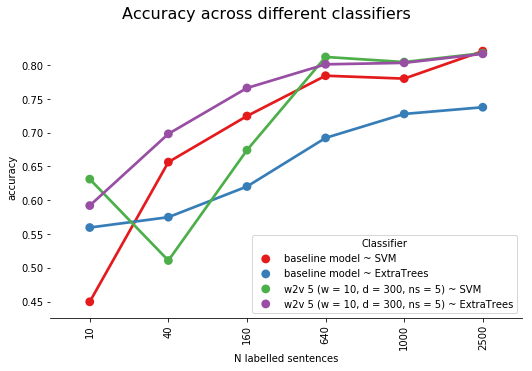

In [476]:
create_pointplot(baseline_df_7, 'accuracy', hue='Classifier', size=5, aspect=1.5,
                 title="Accuracy across different classifiers")